In [1]:
import sys
print(sys.executable)

d:\dev\music-recsys\venv\Scripts\python.exe


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

## 1. Preparação e Análise Exploratória dos Dados

Nesta seção são realizadas a leitura do dataset, análise estatística inicial,
criação de sessões de escuta e definição dos itens musicais utilizados
ao longo do trabalho.

In [3]:
# 1.LEITURA DA BASE DE DADOS LAST.FM 1K-USERS
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "lastfm-1k"
path = DATA_DIR / "userid-timestamp-artid-artname-traid-traname.tsv"

df = pd.read_csv(
    path,
    sep="\t",
    header=None,
    names=["user_id", "timestamp", "artist_id", "artist_name", "track_id", "track_name"],
    engine="python",
    on_bad_lines="skip"
)

print("Linhas:", len(df))
print("Usuários únicos:", df["user_id"].nunique())
df.head()



Linhas: 19128037
Usuários únicos: 992


,user_id,timestamp,artist_id,artist_name,track_id,track_name
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [4]:
# 2.EXIBE AS ESTATÍSTICAS BÁSICAS DA BASE DE DADOS

import numpy as np

# 1) Estatísticas básicas
total_lines = len(df)
unique_users = df["user_id"].nunique()

# 2) Normalizar o campo de MBID (artist_id)
# Trata: NaN, vazio, "MBID" literal e espaços
artist_id_clean = (
    df["artist_id"]
    .astype("string")
    .str.strip()
)

has_mbid_mask = (
    artist_id_clean.notna() &
    (artist_id_clean != "") &
    (artist_id_clean.str.upper() != "MBID")
)

# 3) Contagens de ARTISTAS ÚNICOS (por artist_id quando há MBID; por artist_name quando não há)
artists_with_mbid = df.loc[has_mbid_mask, "artist_id"].nunique()
artists_without_mbid = df.loc[~has_mbid_mask, "artist_name"].nunique()

print("=== Data Statistics (Last.fm 1K) ===")
print(f"Total Lines: {total_lines:,}".replace(",", "."))
print(f"Unique Users: {unique_users:,}".replace(",", "."))
print(f"Artists with MBID (unique artist_id): {artists_with_mbid:,}".replace(",", "."))
print(f"Artists without MBID (unique artist_name): {artists_without_mbid:,}".replace(",", "."))


=== Data Statistics (Last.fm 1K) ===
Total Lines: 19.128.037
Unique Users: 992
Artists with MBID (unique artist_id): 107.320
Artists without MBID (unique artist_name): 69.413


In [5]:
# 3.MOSTRA QUANTOS PLAYS TEM O MBID (MusicBrainz ID) E QUANTOS NÃO TEM
plays_with_mbid = int(has_mbid_mask.sum())
plays_without_mbid = int((~has_mbid_mask).sum())

print(f"Plays with MBID: {plays_with_mbid:,}".replace(",", "."))
print(f"Plays without MBID: {plays_without_mbid:,}".replace(",", "."))

Plays with MBID: 18.526.823
Plays without MBID: 601.214


In [6]:
# 4.DETECTA O TIPO DA CÉLULA (EPOCH OU STRING UTC)
df["timestamp"].head(5), df["timestamp"].dtype
df["timestamp"].astype("string").head(5)


0    2009-05-04T23:08:57Z
1    2009-05-04T13:54:10Z
2    2009-05-04T13:52:04Z
3    2009-05-04T13:42:52Z
4    2009-05-04T13:42:11Z
Name: timestamp, dtype: string

In [7]:
# 5.CONVERTE TIMESTAMP PARA DATETIME

df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")


In [8]:
# 6.Remover timestamps inválidos gerados por errors="coerce" (só por segurança)
before = len(df)
df = df.dropna(subset=["timestamp"]).copy()
print("Linhas removidas por timestamp inválido:", before - len(df))


Linhas removidas por timestamp inválido: 0


In [9]:
# 7.ORDENA POR USUÁRIO
df = df.sort_values(["user_id", "timestamp"]).reset_index(drop=True)
df.head()

# pd.set_option("display.max_rows", 150)
# pd.set_option("display.max_columns", None)

# df.head(150)


,user_id,timestamp,artist_id,artist_name,track_id,track_name
0,user_000001,2006-08-13 13:59:20+00:00,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,c4633ab1-e715-477f-8685-afa5f2058e42,The Launching Of Big Face
1,user_000001,2006-08-13 14:03:29+00:00,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,bc2765af-208c-44c5-b3b0-cf597a646660,Zn Zero
2,user_000001,2006-08-13 14:10:43+00:00,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,aa9c5a80-5cbe-42aa-a966-eb3cfa37d832,The Return Of Super Barrio - End Credits
3,user_000001,2006-08-13 14:17:40+00:00,67fb65b5-6589-47f0-9371-8a40eb268dfb,Tommy Guerrero,d9b1c1da-7e47-4f97-a135-77260f2f559d,Mission Flats
4,user_000001,2006-08-13 14:19:06+00:00,1cfbc7d1-299c-46e6-ba4c-1facb84ba435,Artful Dodger,120bb01c-03e4-465f-94a0-dce5e9fac711,What You Gonna Do?


In [10]:
# gaps entre músicas (em minutos), ignorando primeiros eventos
# para avaliar mudanças de sessão
all_deltas = (
    df.groupby("user_id")["timestamp"]
      .diff()
      .dt.total_seconds()
      .div(60)
      .dropna()
)

all_deltas.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count    1.912704e+07
mean     6.556312e+01
std      3.546708e+03
min      0.000000e+00
50%      4.000000e+00
75%      5.200000e+00
90%      8.316667e+00
95%      2.556667e+01
99%      1.083267e+03
max      2.320830e+06
Name: timestamp, dtype: float64

In [12]:
# Um dicionário de apresentação (ID → artista/faixa). Isso te salva tempo no híbrido.

item_meta = (
    df[["track_id", "artist_name", "track_name"]]
    .dropna()
    .drop_duplicates("track_id")
    .rename(columns={"track_id": "item"})
    .set_index("item")
)

item_meta.reset_index().to_parquet("data/item_meta.parquet", index=False)
print("✅ Salvo: data/item_meta.parquet | Itens:", len(item_meta))


✅ Salvo: data/item_meta.parquet | Itens: 960583


In [13]:
# 8.CRIA SESSÕES (PARTICULARIDADE DO MEU TCC)

import numpy as np

SESSION_GAP_MIN = 20

# Diferença de tempo entre eventos consecutivos por usuário
delta = df.groupby("user_id")["timestamp"].diff()

# marca início de sessão quando:
# - é o primeiro evento do usuário (delta NaT), ou
# - gap > 20 min
new_session = delta.isna() | (delta > pd.Timedelta(minutes=SESSION_GAP_MIN))

# id incremental de sessão por usuário
df["session_id"] = new_session.groupby(df["user_id"]).cumsum()

# id global (opcional, mas facilita)
df["session_uid"] = df["user_id"].astype(str) + "_" + df["session_id"].astype(str)

In [14]:
# 9.EXIBE AS ESTATÍSTICAS DAS SESSÕES
session_sizes = df.groupby("session_uid").size()

print("Sessões únicas:", df["session_uid"].nunique())
print("Tamanho médio da sessão:", session_sizes.mean())
print("Mediana:", session_sizes.median())
print("Percentis (25/75/90/95):", session_sizes.quantile([0.25, 0.75, 0.90, 0.95]).to_dict())


Sessões únicas: 1041286
Tamanho médio da sessão: 18.369628517045268
Mediana: 9.0
Percentis (25/75/90/95): {0.25: 3.0, 0.75: 20.0, 0.9: 41.0, 0.95: 64.0}


In [15]:
# 10.FILTRAR SESSÕES CURTAS

MIN_SESSION_LEN = 2

valid_sessions = session_sizes[session_sizes >= MIN_SESSION_LEN].index
df_sess = df[df["session_uid"].isin(valid_sessions)].copy()

print("Sessões após filtro:", df_sess["session_uid"].nunique())
print("Linhas após filtro:", len(df_sess))
#print("Colunas do df_sess:", df_sess.columns.tolist())

Sessões após filtro: 899411
Linhas após filtro: 18986162


In [16]:
# 11.SALVAR DATASET COM AS SESSÕES

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
out_path = PROJECT_ROOT / "data" / "processed" / "lastfm_with_sessions.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

df_sess.to_parquet(out_path, index=False, engine="pyarrow")
print("✅ Salvo: data/df_sess.parquet | Linhas:", len(df_sess))

df_chk = pd.read_parquet(out_path)
print("Carregado:", len(df_chk), "linhas")
print("Colunas:", df_chk.columns.tolist())
print("Tipos:\n", df_chk.dtypes)
#df_chk.head()


✅ Salvo: data/df_sess.parquet | Linhas: 18986162
Carregado: 18986162 linhas
Colunas: ['user_id', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name', 'session_id', 'session_uid']
Tipos:
 user_id                        str
timestamp      datetime64[us, UTC]
artist_id                      str
artist_name                    str
track_id                       str
track_name                     str
session_id                   int64
session_uid                    str
dtype: object


In [ ]:
# 12.VERIFICA QUANTOS ITENS SÃO NULOS EM "track_id" E EM "track_name" APÓS CRIAR AS SESSÕES

import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
path = PROJECT_ROOT / "data" / "processed" / "lastfm_with_sessions.parquet"

df_sess = pd.read_parquet(path)

print("Nulos em track_id:", df_sess["track_id"].isna().mean())
print("Nulos em track_name:", df_sess["track_name"].isna().mean())


Nulos em track_id: 0.11209658908419722
Nulos em track_name: 1.0744667616340785e-05


In [18]:
# 13. DEFINIÇÃO FINAL DE CADA ITEM (sempre legível)
# item = "artist_name — track_name" (para apresentação e consistência)

df_sess = df_sess.copy()

df_sess["artist_name"] = df_sess["artist_name"].astype("string").str.strip()
df_sess["track_name"]  = df_sess["track_name"].astype("string").str.strip()

df_sess["item"] = (df_sess["artist_name"].fillna("") + " — " + df_sess["track_name"].fillna("")).str.strip()

# remove itens vazios (quase nunca)
before = len(df_sess)
df_sess = df_sess[df_sess["item"].notna() & (df_sess["item"] != "—") & (df_sess["item"] != "")].copy()
print("Linhas removidas por item inválido:", before - len(df_sess))

print("Itens únicos:", df_sess["item"].nunique())
df_sess[["user_id", "timestamp", "session_uid", "artist_name", "track_name", "item"]].head()

Linhas removidas por item inválido: 0
Itens únicos: 1485067


,user_id,timestamp,session_uid,artist_name,track_name,item
0,user_000001,2006-08-13 13:59:20+00:00,user_000001_1,Plaid & Bob Jaroc,The Launching Of Big Face,Plaid & Bob Jaroc — The Launching Of Big Face
1,user_000001,2006-08-13 14:03:29+00:00,user_000001_1,Plaid & Bob Jaroc,Zn Zero,Plaid & Bob Jaroc — Zn Zero
2,user_000001,2006-08-13 14:10:43+00:00,user_000001_1,Plaid & Bob Jaroc,The Return Of Super Barrio - End Credits,Plaid & Bob Jaroc — The Return Of Super Barrio...
3,user_000001,2006-08-13 14:17:40+00:00,user_000001_1,Tommy Guerrero,Mission Flats,Tommy Guerrero — Mission Flats
4,user_000001,2006-08-13 14:19:06+00:00,user_000001_1,Artful Dodger,What You Gonna Do?,Artful Dodger — What You Gonna Do?


In [19]:
# 13.1 CRIAR COLUNAS DE ID (track_id) PARA USO NO ALS / HÍBRIDO
# Mantém item legível (artist — track) para apresentação,
# e cria item_id = track_id para modelagem.
# =========================================================

# item legível já existe em df_sess["item"]
# aqui garantimos que track_id está limpo
df_sess["track_id"] = df_sess["track_id"].astype("string").str.strip()

# ID canônico do item (para ALS / integração)
df_sess["item_id"] = df_sess["track_id"]

# track_id ausente (contagem) — só para diagnóstico
miss = df_sess["track_id"].isna().sum()
print("track_id ausentes (no df_sess):", miss)

# para o ALS/híbrido (itens com ID), crie uma visão filtrada
df_sess_ids = df_sess.dropna(subset=["track_id"]).copy()
df_sess_ids["item_id"] = df_sess_ids["track_id"].astype("string").str.strip()

print("Linhas com track_id válido (para ALS):", len(df_sess_ids))

# item_meta para display (id -> nomes)
item_meta = (
    df_sess[["item_id", "artist_name", "track_name"]]
    .dropna(subset=["item_id"])
    .drop_duplicates("item_id")
    .set_index("item_id")
)

# salvar item_meta para o notebook ALS/híbrido
import os
os.makedirs("data", exist_ok=True)
item_meta.reset_index().to_parquet("data/item_meta.parquet", index=False)
print("✅ Salvo: data/item_meta.parquet | itens:", len(item_meta))


track_id ausentes (no df_sess): 2128284
Linhas com track_id válido (para ALS): 16857878
✅ Salvo: data/item_meta.parquet | itens: 958342


## 2. Modelo Sequencial Base – Markov de Primeira Ordem

Nesta etapa é implementado um modelo sequencial simples baseado em cadeias de Markov de primeira ordem, no qual a recomendação do próximo item depende exclusivamente da música atualmente em reprodução.

In [20]:
# 14.CRIAÇÃO DE PARES

# Ordenação de segurança
df_sess = df_sess.sort_values(["session_uid", "timestamp"]).reset_index(drop=True)

# Próximo item dentro da sessão
df_sess["next_item"] = df_sess.groupby("session_uid")["item"].shift(-1)

# Remover últimas interações da sessão (não têm próximo item)
pairs = df_sess.dropna(subset=["next_item"]).copy()

# Remover auto-transições (mesma música repetida)
pairs = pairs[pairs["item"] != pairs["next_item"]].copy()

print("Total de pares (estado → próximo):", len(pairs))
pairs[["user_id", "session_uid", "timestamp", "item", "next_item"]].head()


Total de pares (estado → próximo): 17567523


,user_id,session_uid,timestamp,item,next_item
0,user_000001,user_000001_1,2006-08-13 13:59:20+00:00,Plaid & Bob Jaroc — The Launching Of Big Face,Plaid & Bob Jaroc — Zn Zero
1,user_000001,user_000001_1,2006-08-13 14:03:29+00:00,Plaid & Bob Jaroc — Zn Zero,Plaid & Bob Jaroc — The Return Of Super Barrio...
2,user_000001,user_000001_1,2006-08-13 14:10:43+00:00,Plaid & Bob Jaroc — The Return Of Super Barrio...,Tommy Guerrero — Mission Flats
3,user_000001,user_000001_1,2006-08-13 14:17:40+00:00,Tommy Guerrero — Mission Flats,Artful Dodger — What You Gonna Do?
4,user_000001,user_000001_1,2006-08-13 14:19:06+00:00,Artful Dodger — What You Gonna Do?,Rei Harakami — Joy


In [21]:
# 15.ESTATÍSTICAS DO DATASET DE PARES

print("Pares únicos:", len(pairs))
print("Itens únicos (origem):", pairs["item"].nunique())
print("Itens únicos (destino):", pairs["next_item"].nunique())

Pares únicos: 17567523
Itens únicos (origem): 1447247
Itens únicos (destino): 1453807


In [ ]:
# Pares com duas visões (legível + ID)

import pandas as pd

# 0) Garante uma visão com IDs válidos (para ALS/híbrido)
df_sess_ids = df_sess.dropna(subset=["track_id"]).copy()
df_sess_ids["item_id"] = df_sess_ids["track_id"].astype("string").str.strip()

# 1) Ordenação é CRÍTICA para o shift representar "próxima faixa"
#    (mantém sequência temporal dentro da sessão)
df_sess_ids = df_sess_ids.sort_values(["user_id", "session_id", "timestamp"]).reset_index(drop=True)

# 2) Cria os pares:
#    - next_item (legível)
#    - next_item_id (track_id)
df_sess_ids["next_item"] = df_sess_ids.groupby(["user_id", "session_id"])["item"].shift(-1)
df_sess_ids["next_item_id"] = df_sess_ids.groupby(["user_id", "session_id"])["item_id"].shift(-1)

# 3) Remove o último play de cada sessão (não tem próxima faixa)
pairs = df_sess_ids.dropna(subset=["next_item", "next_item_id"]).copy()

# 4) Seleciona as colunas finais de pares
pairs = pairs[[
    "user_id", "session_id", "timestamp",
    "item", "next_item",
    "item_id", "next_item_id"
]].copy()

print("pairs:", pairs.shape)
display(pairs.head(10))

pairs: (15983718, 7)


,user_id,session_id,timestamp,item,next_item,item_id,next_item_id
0,user_000001,1,2006-08-13 13:59:20+00:00,Plaid & Bob Jaroc — The Launching Of Big Face,Plaid & Bob Jaroc — Zn Zero,c4633ab1-e715-477f-8685-afa5f2058e42,bc2765af-208c-44c5-b3b0-cf597a646660
1,user_000001,1,2006-08-13 14:03:29+00:00,Plaid & Bob Jaroc — Zn Zero,Plaid & Bob Jaroc — The Return Of Super Barrio...,bc2765af-208c-44c5-b3b0-cf597a646660,aa9c5a80-5cbe-42aa-a966-eb3cfa37d832
2,user_000001,1,2006-08-13 14:10:43+00:00,Plaid & Bob Jaroc — The Return Of Super Barrio...,Tommy Guerrero — Mission Flats,aa9c5a80-5cbe-42aa-a966-eb3cfa37d832,d9b1c1da-7e47-4f97-a135-77260f2f559d
3,user_000001,1,2006-08-13 14:17:40+00:00,Tommy Guerrero — Mission Flats,Artful Dodger — What You Gonna Do?,d9b1c1da-7e47-4f97-a135-77260f2f559d,120bb01c-03e4-465f-94a0-dce5e9fac711
4,user_000001,1,2006-08-13 14:19:06+00:00,Artful Dodger — What You Gonna Do?,Rei Harakami — Joy,120bb01c-03e4-465f-94a0-dce5e9fac711,777ac51f-8ffc-4c44-92b6-a2c75cbc6915
6,user_000001,2,2006-08-13 14:44:23+00:00,Rei Harakami — Lust,Herbie Hancock — The Essence,328913b8-f31f-4abf-976e-7641174f680b,8e81302a-6cde-4818-8703-43b5356ce0a0
7,user_000001,2,2006-08-13 14:55:14+00:00,Herbie Hancock — The Essence,Radiohead — Idioteque,8e81302a-6cde-4818-8703-43b5356ce0a0,1c0377bb-c00b-4bbe-b4b2-615f13324adc
8,user_000001,2,2006-08-13 14:59:59+00:00,Radiohead — Idioteque,高木正勝 — Change Of Seasons,1c0377bb-c00b-4bbe-b4b2-615f13324adc,8f916d23-0510-4ad5-9a7f-8a076c3f14ca
9,user_000001,2,2006-08-13 15:05:20+00:00,高木正勝 — Change Of Seasons,Black Jazz Chronicles — Dope Stuff,8f916d23-0510-4ad5-9a7f-8a076c3f14ca,9f51e011-56cf-459e-9077-e928bbb13ff4
10,user_000001,2,2006-08-13 15:12:12+00:00,Black Jazz Chronicles — Dope Stuff,Valerie Etienne — The Birds Sing,9f51e011-56cf-459e-9077-e928bbb13ff4,4c7d5a2c-e1da-4fe3-96e3-c40a7a6f59e8


In [23]:
# VERIFICA SE FICOU ID's QUEBRADOS

print("Missing next_item_id:", pairs["next_item_id"].isna().sum())
print("Missing next_item:", pairs["next_item"].isna().sum())

Missing next_item_id: 0
Missing next_item: 0


In [24]:
# SALVA PARES PARA REPRODUTIBILIDADE

import os
os.makedirs("data", exist_ok=True)

pairs.to_parquet("data/pairs_full.parquet", index=False)
print("✅ Salvo: data/pairs_full.parquet")

✅ Salvo: data/pairs_full.parquet


In [25]:
# 16.SPLIT TREINO / TESTE (temporal por usuário)

# 1) cria um tempo de referência por sessão (ex.: primeiro timestamp da sessão)
# garante ordem temporal global
pairs_sorted = pairs.sort_values(["user_id", "session_id", "timestamp"]).reset_index(drop=True)

# tempo de referência por sessão (início da sessão)
sess_time = (
    pairs_sorted
    .groupby(["user_id", "session_id"])["timestamp"]
    .min()
    .reset_index(name="session_time")
)

pairs2 = pairs.merge(sess_time, on=["user_id", "session_id"], how="left")

# 2) cutoff temporal por usuário (80% das sessões no tempo)
cutoff = pairs2.groupby("user_id")["session_time"].quantile(0.8)
pairs2["cutoff"] = pairs2["user_id"].map(cutoff)

# 3) split por sessão (não quebra sessão ao meio)
train = pairs2[pairs2["session_time"] <= pairs2["cutoff"]].copy()
test  = pairs2[pairs2["session_time"] >  pairs2["cutoff"]].copy()

train.drop(columns=["cutoff", "session_time"], inplace=True)
test.drop(columns=["cutoff", "session_time"], inplace=True)

print("Train pairs:", len(train))
print("Test pairs:", len(test))

Train pairs: 12820359
Test pairs: 3163359


In [26]:
# SALVAMENTO LEGÍVEL + ID's
os.makedirs("data", exist_ok=True)

# versão completa (para debug e híbrido)
train.to_parquet("data/train_pairs_full.parquet", index=False)
test.to_parquet("data/test_pairs_full.parquet", index=False)

# versão IDs (para ALS/híbrido)
train[["user_id","item_id","next_item_id","session_id","timestamp"]].to_parquet("data/train_pairs_ids.parquet", index=False)
test[["user_id","item_id","next_item_id","session_id","timestamp"]].to_parquet("data/test_pairs_ids.parquet", index=False)

print("✅ Salvo: data/train_pairs_full.parquet, data/test_pairs_full.parquet")
print("✅ Salvo: data/train_pairs_ids.parquet, data/test_pairs_ids.parquet")

✅ Salvo: data/train_pairs_full.parquet, data/test_pairs_full.parquet
✅ Salvo: data/train_pairs_ids.parquet, data/test_pairs_ids.parquet


In [27]:
# AVALIA COBERTURA DO MARKOV NO CONJUNTO DE TESTE

# --- conjuntos do treino ---
train_states = set(train["item"].dropna().unique())
train_pairs_set = set(zip(train["item"].dropna(), train["next_item"].dropna()))

# --- marcações no teste ---
test_eval = test.copy()

test_eval["state_seen_in_train"] = test_eval["item"].isin(train_states)
test_eval["pair_seen_in_train"] = list(zip(test_eval["item"], test_eval["next_item"]))
test_eval["pair_seen_in_train"] = test_eval["pair_seen_in_train"].apply(lambda p: p in train_pairs_set)

# --- métricas ---
n_test = len(test_eval)
pct_state = 100 * test_eval["state_seen_in_train"].mean()
pct_pair  = 100 * test_eval["pair_seen_in_train"].mean()

# fallback por "estado novo" (Markov não tem transições pois não conhece o item)
fallback_state_new = (~test_eval["state_seen_in_train"]).sum()

# fallback por "transição nova" (conhece o estado, mas não viu aquele next específico)
fallback_pair_new = ((test_eval["state_seen_in_train"]) & (~test_eval["pair_seen_in_train"])).sum()

print("===== COBERTURA DO MARKOV NO TESTE =====")
print(f"Total de pares no teste: {n_test:,}")
print(f"Estados do teste vistos no treino: {pct_state:.2f}%")
print(f"Pares (item→next_item) do teste vistos no treino: {pct_pair:.2f}%")

print("\n===== FALLBACK (diagnóstico) =====")
print(f"Fallback por estado novo (item nunca visto no treino): {fallback_state_new:,} ({100*fallback_state_new/n_test:.2f}%)")
print(f"Transição nova (estado visto, mas par não visto):      {fallback_pair_new:,} ({100*fallback_pair_new/n_test:.2f}%)")

# --- (opcional) exemplos para inspecionar ---
print("\nExemplos de estado novo (primeiros 5):")
display(test_eval.loc[~test_eval["state_seen_in_train"], ["user_id","session_id","timestamp","item","next_item"]].head(5))

print("\nExemplos de transição nova (primeiros 5):")
display(test_eval.loc[(test_eval["state_seen_in_train"]) & (~test_eval["pair_seen_in_train"]),
                      ["user_id","session_id","timestamp","item","next_item"]].head(5))

===== COBERTURA DO MARKOV NO TESTE =====
Total de pares no teste: 3,163,359
Estados do teste vistos no treino: 92.28%
Pares (item→next_item) do teste vistos no treino: 36.62%

===== FALLBACK (diagnóstico) =====
Fallback por estado novo (item nunca visto no treino): 244,170 (7.72%)
Transição nova (estado visto, mas par não visto):      1,760,701 (55.66%)

Exemplos de estado novo (primeiros 5):


,user_id,session_id,timestamp,item,next_item
8739,user_000001,1009,2009-01-25 13:55:29+00:00,The Black Dog — Invisible Things (Mescalito Mix),The Black Dog — Transmission Start
8794,user_000001,1025,2009-02-02 06:35:27+00:00,Madlib — Shades Of Pete (Super),Madlib — King Chop (Top Line)
8798,user_000001,1025,2009-02-02 06:42:46+00:00,Madlib — Dill Withers Theme,Madlib — First Class (The Best Catalogue)
8799,user_000001,1025,2009-02-02 06:43:30+00:00,Madlib — First Class (The Best Catalogue),Madlib — Lifetime (Lifeline)
8800,user_000001,1025,2009-02-02 06:44:59+00:00,Madlib — Lifetime (Lifeline),Madlib — The Electric Zone (Plugged In)



Exemplos de transição nova (primeiros 5):


,user_id,session_id,timestamp,item,next_item
8697,user_000001,1005,2009-01-22 14:16:44+00:00,Manuel Tur & Dplay — Rest Your Senses,Foster — Quiet Before The Storm (Quarion Remix)
8698,user_000001,1005,2009-01-22 14:16:44+00:00,Foster — Quiet Before The Storm (Quarion Remix),Soultourist — Turn Loose (Dixon Edit)
8700,user_000001,1006,2009-01-23 13:15:03+00:00,Manuel Tur & Dplay — Rest Your Senses,Manuel Tur & Dplay — Rest Your Senses
8702,user_000001,1006,2009-01-23 13:20:24+00:00,Soultourist — Turn Loose (Dixon Edit),Soultourist — Turn Loose (Dixon Edit)
8705,user_000001,1006,2009-01-23 13:31:34+00:00,Sasha Dive — Deep (Samuel Davis Deep4Life Mix),Kawabata — Movin' On


In [ ]:
# AVALIA QUALIDADE DO SPLIT

import numpy as np

n_users_train = train["user_id"].nunique()
n_users_test  = test["user_id"].nunique()

users_no_test = set(train["user_id"].unique()) - set(test["user_id"].unique())

print("Usuários no train:", n_users_train)
print("Usuários no test :", n_users_test)
print("Usuários sem nenhum par no test:", len(users_no_test), f"({100*len(users_no_test)/n_users_train:.2f}%)")

# sessões e pares no teste
print("\nSessões no test:", test["session_id"].nunique())
print("Pares no test:", len(test))

# distribuição de pares por usuário no teste (para ver cauda curta)
pairs_per_user_test = test.groupby("user_id").size()

print("\nPares por usuário no test (resumo):")
print(pairs_per_user_test.describe())

# quantos usuários têm menos de X pares no teste?
for x in [1, 2, 5, 10]:
    print(f"Usuários com <= {x} pares no test:", int((pairs_per_user_test <= x).sum()))

Usuários no train: 990
Usuários no test : 971
Usuários sem nenhum par no test: 19 (1.92%)

Sessões no test: 6855
Pares no test: 3163359

Pares por usuário no test (resumo):
count      971.000000
mean      3257.836251
std       4013.079704
min          1.000000
25%        629.500000
50%       1950.000000
75%       4220.500000
max      31742.000000
dtype: float64
Usuários com <= 1 pares no test: 2
Usuários com <= 2 pares no test: 3
Usuários com <= 5 pares no test: 7
Usuários com <= 10 pares no test: 14


In [28]:
# 18.CONTAR TRANSIÇÕES (item → próximo)

train["item"] = train["item"].astype("category")
train["next_item"] = train["next_item"].astype("category")
test["item"] = test["item"].astype("category")
test["next_item"] = test["next_item"].astype("category")

transition_counts = (
    train
    .groupby(["item", "next_item"], observed=True)
    .size()
    .rename("count")
    .reset_index()
)

transition_counts.head()

,item,next_item,count
0,!Action Pact! — All Purpose Action Footwear,!Action Pact! — Suicide Bag,2
1,!Action Pact! — Blue Blood,Bread And Water — Death Sentence,1
2,!Action Pact! — Cocktail Credibility,Bella Morte — Doubt,1
3,!Action Pact! — Gothic Party Time,!Action Pact! — New King'S Girl,1
4,!Action Pact! — Gothic Party Time,Angry Samoans — Lights Out,1


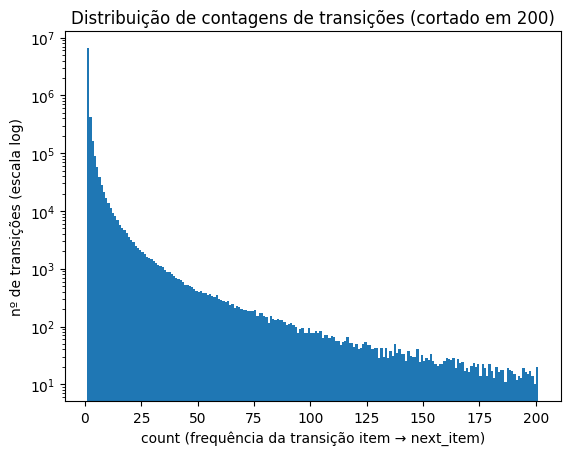

Proporção count=1: 0.8711554001759085
Max count: 1575


In [ ]:
# 18.1.HISTGRAMA

import numpy as np
import matplotlib.pyplot as plt

counts = transition_counts["count"].to_numpy()

# bins inteiros (1..máximo)
max_c = int(counts.max())
bins = np.arange(1, min(max_c, 200) + 2)  # até 200 por padrão

plt.figure()
plt.hist(counts[counts <= (bins[-1]-1)], bins=bins, edgecolor=None)
plt.yscale("log")
plt.xlabel("count (frequência da transição item → next_item)")
plt.ylabel("nº de transições (escala log)")
plt.title("Distribuição de contagens de transições (cortado em 200)")
plt.show()

print("Proporção count=1:", (counts == 1).mean())
print("Max count:", max_c)

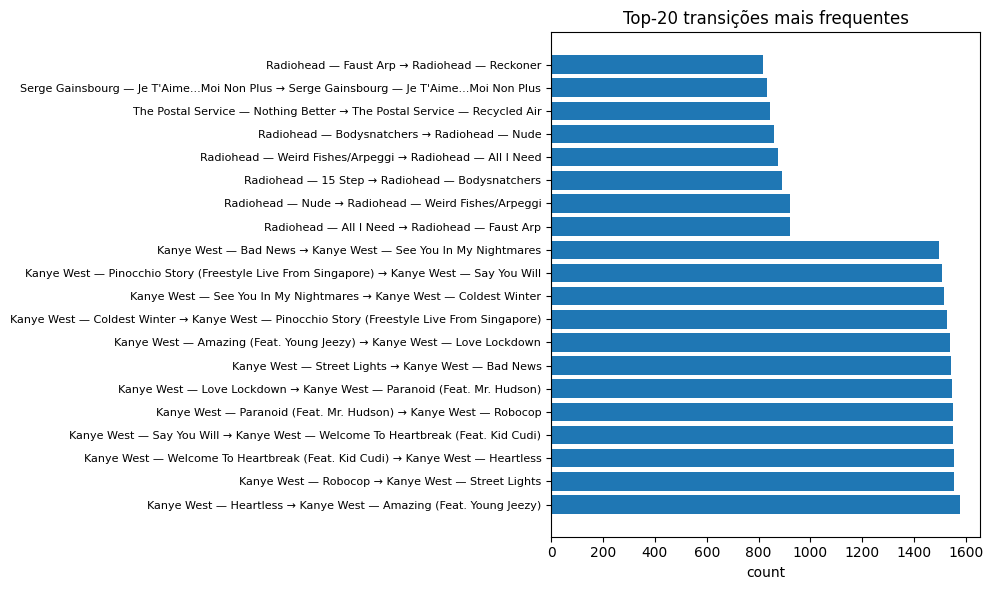

In [30]:
# 18.2.TOP-20 TRANSIÇÕES

import matplotlib.pyplot as plt

topN = 20
top_trans = transition_counts.sort_values("count", ascending=False).head(topN).copy()

labels = (top_trans["item"].astype(str) + " → " + top_trans["next_item"].astype(str)).to_list()
values = top_trans["count"].to_list()

plt.figure(figsize=(10, 6))
plt.barh(range(len(values))[::-1], values[::-1])
plt.yticks(range(len(values))[::-1], labels[::-1], fontsize=8)
plt.xlabel("count")
plt.title(f"Top-{topN} transições mais frequentes")
plt.tight_layout()
plt.show()

In [31]:
# Avalia cobertura de estados do treino

n_states = transition_counts["item"].nunique()
n_pairs  = len(transition_counts)

print("Estados distintos (item):", n_states)
print("Transições distintas (item → next_item):", n_pairs)

Estados distintos (item): 832937
Transições distintas (item → next_item): 7501626


In [32]:
# Avalia Distribuição de transições por estado (sparsity)

out_degree = transition_counts.groupby("item")["next_item"].nunique()

print("Resumo do nº de possíveis próximas músicas por item:")
print(out_degree.describe())

print("\nItens com apenas 1 transição possível:", int((out_degree == 1).sum()))
print("Itens com <= 3 transições possíveis:", int((out_degree <= 3).sum()))

Resumo do nº de possíveis próximas músicas por item:
count    832937.000000
mean          9.006235
std          27.559830
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max        1558.000000
Name: next_item, dtype: float64

Itens com apenas 1 transição possível: 299357
Itens com <= 3 transições possíveis: 504883


In [33]:
# 23.PRÓXIMO ITEM MAIS FREQUENTE - BASELINE 1 - MARKOV ORDEM-1- POPOULARIDADE CONDICIONAL
# "Qual é a música mais provável depois da atual?"

top_next = (
    transition_counts
    .sort_values(["item", "count"], ascending=[True, False])
    .groupby("item")
    .head(1)
    .reset_index(drop=True)
)

top_next.head()

,item,next_item,count
0,!Action Pact! — All Purpose Action Footwear,!Action Pact! — Suicide Bag,2
1,!Action Pact! — Blue Blood,Bread And Water — Death Sentence,1
2,!Action Pact! — Cocktail Credibility,Bella Morte — Doubt,1
3,!Action Pact! — Gothic Party Time,!Action Pact! — New King'S Girl,1
4,"!Action Pact! — Hook, Line And Sinker",!Action Pact! — Suss Of The Swiss,1


In [34]:
# 24.GERAR TOP-K POR ITEM (A PARTIR DO TREINO)
def make_topk_table(transition_counts: pd.DataFrame, K: int) -> pd.DataFrame:
    topk = (
        transition_counts
        .sort_values(["item", "count"], ascending=[True, False])
        .copy()
    )
    topk["rank"] = topk.groupby("item").cumcount() + 1
    topk = topk[topk["rank"] <= K][["item", "next_item", "rank", "count"]]
    return topk

# GERAR TOP-20 UMA VEZ SÓ
K_MAX = 20  # guarda 20 vizinhos por item; depois você usa K=5,10,etc.

topk_df = make_topk_table(transition_counts, K=K_MAX)
topk_df.head()


,item,next_item,rank,count
0,!Action Pact! — All Purpose Action Footwear,!Action Pact! — Suicide Bag,1,2
1,!Action Pact! — Blue Blood,Bread And Water — Death Sentence,1,1
2,!Action Pact! — Cocktail Credibility,Bella Morte — Doubt,1,1
3,!Action Pact! — Gothic Party Time,!Action Pact! — New King'S Girl,1,1
4,!Action Pact! — Gothic Party Time,Angry Samoans — Lights Out,2,1


In [35]:
# GERA TOP-K COM IDS PARA ALS / HÍBRIDO
# =========================================================

train["item_id"] = train["item_id"].astype("category")
train["next_item_id"] = train["next_item_id"].astype("category")

transition_counts_ids = (
    train
    .groupby(["item_id", "next_item_id"], observed=True)
    .size()
    .rename("count")
    .reset_index()
)

def make_topk_table_ids(df: pd.DataFrame, K: int) -> pd.DataFrame:
    topk = df.sort_values(
        ["item_id", "count"], ascending=[True, False]
    ).copy()
    topk["rank"] = topk.groupby("item_id").cumcount() + 1
    return topk[topk["rank"] <= K][["item_id", "next_item_id", "rank", "count"]]

K_MAX = 20
topk_df_ids = make_topk_table_ids(transition_counts_ids, K=K_MAX)

topk_df_ids.head()

,item_id,next_item_id,rank,count
0,00000891-ca9c-490c-9fae-fff04957c9ef,310706e1-7363-4cc1-bce0-89f7c6ffedb2,1,1
1,00000891-ca9c-490c-9fae-fff04957c9ef,35f02ad9-231f-4615-b71c-c47f30e56771,2,1
2,00000891-ca9c-490c-9fae-fff04957c9ef,4f01c986-85cd-4a74-8771-2e97d9a08c2b,3,1
3,00000891-ca9c-490c-9fae-fff04957c9ef,78f443ce-85ec-4bfc-809f-d2006a6d49e5,4,1
4,00000baf-9215-483a-8900-93756eaf1cfc,0a48531c-e315-48d5-a50c-913468ee492c,1,1


In [36]:
# SALVAR ARTEFATOS DO MARKOV E COM IDS

os.makedirs("data", exist_ok=True)

topk_df.to_parquet("data/topk_markov_legivel.parquet", index=False)
topk_df_ids.to_parquet("data/topk_markov_ids.parquet", index=False)

transition_counts.to_parquet("data/transition_counts_legivel.parquet", index=False)
transition_counts_ids.to_parquet("data/transition_counts_ids.parquet", index=False)

print("✅ Markov artefatos salvos")

✅ Markov artefatos salvos


In [60]:
# SALVA ALS_EVENTS 

import os

os.makedirs("data", exist_ok=True)

cols_als = ["user_id", "track_id", "timestamp", "artist_name", "track_name"]
df_als_events =(
    df_sess[cols_als]
    .dropna(subset=["user_id", "track_id", "timestamp"])
    .rename(columns={"track_id": "item"})
    .copy()
)

# Parquet (melhor para notebook)
df_als_events.to_parquet("data/als_events.parquet", index=False)

print("Salvo:", "data/als_events.parquet", "| Linhas:", len(df_als_events))
df_als_events.head()


Salvo: data/als_events.parquet | Linhas: 16857878


,user_id,item,timestamp,artist_name,track_name
0,user_000001,c4633ab1-e715-477f-8685-afa5f2058e42,2006-08-13 13:59:20+00:00,Plaid & Bob Jaroc,The Launching Of Big Face
1,user_000001,bc2765af-208c-44c5-b3b0-cf597a646660,2006-08-13 14:03:29+00:00,Plaid & Bob Jaroc,Zn Zero
2,user_000001,aa9c5a80-5cbe-42aa-a966-eb3cfa37d832,2006-08-13 14:10:43+00:00,Plaid & Bob Jaroc,The Return Of Super Barrio - End Credits
3,user_000001,d9b1c1da-7e47-4f97-a135-77260f2f559d,2006-08-13 14:17:40+00:00,Tommy Guerrero,Mission Flats
4,user_000001,120bb01c-03e4-465f-94a0-dce5e9fac711,2006-08-13 14:19:06+00:00,Artful Dodger,What You Gonna Do?


In [37]:
# 20.ITEM LOOKUP

# Lookup de metadados por item (para explicação e diversidade)
item_meta = (
    df_sess[["item", "artist_name", "track_name"]]
    .dropna(subset=["item"])
    .drop_duplicates("item")
    .set_index("item")
)

def item_to_str(item_id: str, lookup=item_meta) -> str:
    if item_id in lookup.index:
        row = lookup.loc[item_id]
        return f"{row['artist_name']} — {row['track_name']}"
    return str(item_id)

def get_artist(item_id: str) -> str:
    if item_id in item_meta.index:
        a = item_meta.loc[item_id, "artist_name"]
        return a if isinstance(a, str) else ""
    return ""

def get_track(item_id: str) -> str:
    if item_id in item_meta.index:
        t = item_meta.loc[item_id, "track_name"]
        return t if isinstance(t, str) else ""
    return ""

In [38]:
# LOOKUP POR ID (track_id) — para ALS / híbrido
# =========================================================

item_meta_id = (
    df_sess[["item_id", "artist_name", "track_name"]]
    .dropna(subset=["item_id"])
    .drop_duplicates("item_id")
    .set_index("item_id")
)

def item_id_to_str(item_id: str, lookup=item_meta_id) -> str:
    if item_id in lookup.index:
        row = lookup.loc[item_id]
        return f"{row['artist_name']} — {row['track_name']}"
    return str(item_id)

def get_artist_id(item_id: str) -> str:
    if item_id in item_meta_id.index:
        a = item_meta_id.loc[item_id, "artist_name"]
        return a if isinstance(a, str) else ""
    return ""

def get_track_id(item_id: str) -> str:
    if item_id in item_meta_id.index:
        t = item_meta_id.loc[item_id, "track_name"]
        return t if isinstance(t, str) else ""
    return ""

In [39]:
# 19.GERAR POPULARIDADE GLOBAL GERAL DA BASE

# Popularidade global geral (itens como origem + destino)
pop_all = pd.concat([train["item"], train["next_item"]], ignore_index=True)

global_rank = pop_all.value_counts().head(200).reset_index()
global_rank.columns = ["item", "pop_count"]
global_rank["rank"] = range(1, len(global_rank) + 1)

print("Top-5 global (geral):")
global_rank.head()

Top-5 global (geral):


,item,pop_count,rank
0,The Postal Service — Such Great Heights,6541,1
1,Death Cab For Cutie — Soul Meets Body,5568,2
2,Boy Division — Love Will Tear Us Apart,5357,3
3,Muse — Supermassive Black Hole,5103,4
4,Arcade Fire — Rebellion (Lies),5093,5


In [40]:
# GERA GLOBAL RANK COM IDs PARA ALS/HÍBRIDO
pop_all_ids = pd.concat([train["item_id"], train["next_item_id"]], ignore_index=True)

global_rank_ids = pop_all_ids.value_counts().reset_index()
global_rank_ids.columns = ["item_id", "pop_count"]
global_rank_ids["rank"] = range(1, len(global_rank_ids) + 1)

global_rank_ids_200 = global_rank_ids.head(200).copy()

print("Top-5 global (IDs):")
display(global_rank_ids_200.head())

Top-5 global (IDs):


,item_id,pop_count,rank
0,db16d0b3-b8ce-4aa8-a11a-e4d53cc7f8a6,6541,1
1,4e17b118-70a6-4c1f-b326-b4ce91fd3fad,5568,2
2,7f1f45c0-0101-49e9-8d69-23951d271163,5357,3
3,ff1e3e1a-f6e8-4692-b426-355880383bb6,5103,4
4,f874c752-65bc-4d50-ac7e-932243ae9f02,5093,5


In [42]:
# SALVAMENTO

import os
os.makedirs("data", exist_ok=True)

global_rank.to_parquet("data/global_rank_top200.parquet", index=False)
global_rank_ids_200.to_parquet("data/global_rank_ids_top200.parquet", index=False)

print("✅ Salvo: global_rank_top200.parquet e global_rank_ids_top200.parquet")

✅ Salvo: global_rank_top200.parquet e global_rank_ids_top200.parquet


In [43]:
# 21. DETECTOR DE ALBUM_MODE + FALLBACK DIVERSIFICADO

def is_album_mode(recent_artists, window=5, min_same=4):
    """
    Detecta 'album_mode' se, nas últimas 'window' músicas,
    pelo menos 'min_same' forem do mesmo artista.
    """
    recent = [a for a in recent_artists[-window:] if isinstance(a, str) and a.strip()]
    if len(recent) < window:
        return False
    top = max(set(recent), key=recent.count)
    return recent.count(top) >= min_same


def choose_diverse_fallback(
    global_rank_df: pd.DataFrame,
    recent_items: list,
    recent_artists: list,
    top_pool: int = 50,
    max_per_artist: int = 1,
    sample_from_top_n_eligible: int = 15,
    seed: int | None = None,
):
    """
    global_rank_df: DataFrame com colunas ["item", "pop_count"] ordenado desc.
    recent_items: lista de itens tocados recentemente (para evitar repetir)
    recent_artists: lista de artistas recentes (para detectar album_mode e evitar repetição de artista)
    top_pool: pega os 'top_pool' itens mais populares como pool de escolha
    max_per_artist: se NÃO album_mode, limita quantas vezes um artista pode aparecer na janela recente
    """

    rng = np.random.default_rng(seed)

    pool = global_rank_df.head(top_pool)["item"].tolist()
    recent_set = set(recent_items)

    album_mode = is_album_mode(recent_artists, window=5, min_same=4)

    # conta artistas recentes
    artist_counts = {}
    for a in recent_artists:
        if isinstance(a, str) and a.strip():
            artist_counts[a] = artist_counts.get(a, 0) + 1
    
    eligible = []

    # 1) se NÃO é álbum, tenta evitar repetir artista
    if not album_mode:
        for it in pool:
            if it in recent_set:
                continue
            a = get_artist(it)
            if a and artist_counts.get(a, 0) >= max_per_artist:
                continue
            eligible.append(it)
    
    if eligible:
            # sorteia entre os N elegíveis mais populares
            pick_pool = eligible[:min(sample_from_top_n_eligible, len(eligible))]
            chosen = rng.choice(pick_pool)
            return chosen, {
                "strategy": "popularidade_global_diversa",
                "album_mode": False,
                "top_pool": top_pool,
                "max_per_artist": max_per_artist,
                "n_eligible": len(eligible),
                "sample_from_top_n_eligible": len(pick_pool)
            }

    # 2) se é álbum (ou não achou elegíveis), relaxa artista: só evita repetir item
    eligible = [it for it in pool if it not in recent_set]
    if eligible:
        pick_pool = eligible[:min(sample_from_top_n_eligible, len(eligible))]
        chosen = rng.choice(pick_pool)
        return chosen, {
            "strategy": "popularidade_global_sem_repetir_sorteada",
            "album_mode": album_mode,
            "top_pool": top_pool,
            "n_eligible": len(eligible),
            "sample_from_top_n_eligible": len(pick_pool)
        }

    # 3) último recurso: topo mesmo
    it = pool[0] if pool else None
    return it, {
        "strategy": "popularidade_global_bruta",
        "album_mode": album_mode,
        "top_pool": top_pool
    }

In [45]:
# SALVA OS ITENS

import os
import pandas as pd

os.makedirs("data", exist_ok=True)

df_als_events = df_sess[["user_id", "artist_name", "track_name", "timestamp", "session_id"]].dropna().copy()
df_als_events["item"] = df_als_events["artist_name"].astype(str) + " — " + df_als_events["track_name"].astype(str)

df_als_events = df_als_events[["user_id", "item", "timestamp", "session_id"]]
df_als_events.to_parquet("data/als_events.parquet", index=False)

print("Salvo:", "data/als_events.parquet", "| Linhas:", len(df_als_events))
df_als_events.head()

Salvo: data/als_events.parquet | Linhas: 18985958


,user_id,item,timestamp,session_id
0,user_000001,Plaid & Bob Jaroc — The Launching Of Big Face,2006-08-13 13:59:20+00:00,1
1,user_000001,Plaid & Bob Jaroc — Zn Zero,2006-08-13 14:03:29+00:00,1
2,user_000001,Plaid & Bob Jaroc — The Return Of Super Barrio...,2006-08-13 14:10:43+00:00,1
3,user_000001,Tommy Guerrero — Mission Flats,2006-08-13 14:17:40+00:00,1
4,user_000001,Artful Dodger — What You Gonna Do?,2006-08-13 14:19:06+00:00,1


In [46]:
# Função final do Markov: 1 recomendação + explicação

def recommend_markov_nexttrack(
    current_item: str,
    topk_df: pd.DataFrame,
    global_rank: pd.DataFrame,
    transition_counts: pd.DataFrame,
    recent_items: list | None = None,
    recent_artists: list | None = None,
    K: int = 5,
    seed: int | None = None,
):
    # 1) tenta Markov (Top-K do estado atual)
    cand = topk_df[(topk_df["item"] == current_item) & (topk_df["rank"] <= K)].copy()

    if len(cand) > 0:
        # pega o TOP-1 (rank=1)
        best = cand.sort_values(["rank","count"], ascending=[True, False]).iloc[0]
        next_item = best["next_item"]
        cnt = int(best["count"]) if pd.notna(best["count"]) else None

        explanation = (
            f"Explicação: Em outras sessões de escuta, {item_to_str(next_item)} "
            f"vem depois de {item_to_str(current_item)}"
        )
        if cnt is not None:
            explanation += f" (count={cnt})."

        return next_item, explanation

    # 2) fallback: popularidade global (diversificada)
    recent_items = recent_items or []
    recent_artists = recent_artists or []

    fallback_item, info = choose_diverse_fallback(
        global_rank_df=global_rank,
        recent_items=recent_items,
        recent_artists=recent_artists,
        top_pool=50,
        max_per_artist=1,
        sample_from_top_n_eligible=15,
        seed=seed, 
    )

    explanation = (
        f"Explicação: Como não há dados para definir quais são as possíveis músicas depois de "
        f"{item_to_str(current_item)}, a recomendação foi uma música bastante popular entre os ouvintes "
        f"({info.get('strategy','popularidade_global')})."
    )
    return fallback_item, explanation


### 2.1 Explicabilidade das Recomendações

Cada recomendação gerada pelo sistema é acompanhada de uma explicação
baseada na lógica de decisão adotada, distinguindo-se entre decisões
contextuais (Markov) e estratégias de fallback baseadas em popularidade global.

In [48]:
# TESTE SIMPLES MARKOV DE ORDEM-1
import numpy as np
import pandas as pd
import textwrap

def sample_current_item(
    source_df: pd.DataFrame,
    col: str = "item",
    only_with_markov: bool = False,
    topk_df: pd.DataFrame | None = None,
    seed: int | None = None
) -> str:
    """
    Amostra um item aleatório.
    - only_with_markov=True força pegar um item que aparece como estado no topk_df (ou seja, tem transições no treino)
    - seed=None => aleatório a cada execução
    """
    rng = np.random.default_rng(seed)

    if only_with_markov:
        if topk_df is None:
            raise ValueError("Para only_with_markov=True, você precisa passar topk_df.")
        pool = topk_df["item"].dropna().unique()
    else:
        pool = source_df[col].dropna().unique()

    return rng.choice(pool)


def get_recent_context_from_sessions(
    df_sess: pd.DataFrame,
    session_col: str = "session_id",
    item_col: str = "item",
    max_len: int = 5,
    seed: int | None = None
):
    """
    Tenta extrair um contexto recente real (últimas músicas de uma sessão aleatória).
    Se não existir session_id em df_sess, retorna listas vazias.

    - seed=None => escolhe uma sessão aleatória a cada execução
    """
    if session_col not in df_sess.columns:
        return [], []

    rng = np.random.default_rng(seed)
    sessions = df_sess[session_col].dropna().unique()
    if len(sessions) == 0:
        return [], []

    sid = rng.choice(sessions)
    seq = df_sess[df_sess[session_col] == sid][item_col].dropna().tolist()

    recent_items = seq[-max_len:] if len(seq) else []
    recent_artists = [get_artist(it) for it in recent_items]

    return recent_items, recent_artists


# ==========================
# DEMO / TESTE DA RECOMENDAÇÃO
# ==========================

MODE = "random"  # "markov" | "fallback" | "random"
K = 5

SEED = None  # 

# 2) amostra música atual
if MODE == "markov":
    current_item = sample_current_item(
        train, col="item",
        only_with_markov=True,
        topk_df=topk_df,
        seed=SEED
    )

elif MODE == "fallback":
    markov_states = set(topk_df["item"].dropna().unique())
    pool = [it for it in train["item"].dropna().unique() if it not in markov_states]

    if len(pool) == 0:
        current_item = sample_current_item(train, col="item", seed=SEED)
    else:
        rng = np.random.default_rng(SEED)
        current_item = rng.choice(pool)

else:  # "random"
    current_item = sample_current_item(train, col="item", seed=SEED)

# 3) pega um contexto recente real (se existir session_id em df_sess)
recent_items, recent_artists = get_recent_context_from_sessions(
    df_sess=df_sess,
    session_col="session_id",  # ajuste se tiver outro nome
    item_col="item",
    max_len=5,
    seed=SEED
)

# 4) faz a recomendação
next_item, explanation = recommend_markov_nexttrack(
    current_item=current_item,
    topk_df=topk_df,
    global_rank=global_rank,
    transition_counts=transition_counts,
    recent_items=recent_items,
    recent_artists=recent_artists,
    K=K
)

# 5) imprime o resultado
print("===== TESTE (Next-Track) — Markov ordem 1 =====\n")
print(f"Música atual:     {item_to_str(current_item)}")
print(f"Recomendação:     {item_to_str(next_item)}\n")
print(textwrap.fill(explanation, width=90))


===== TESTE (Next-Track) — Markov ordem 1 =====

Música atual:     Josh Hodges — Little Bit More
Recomendação:     Josh Hodges — Jake - Keep It Together

Explicação: Em outras sessões de escuta, Josh Hodges — Jake - Keep It Together vem depois
de Josh Hodges — Little Bit More (count=1).


In [ ]:
# TESTE DO FALLBACK (DIVERSIFICADO)
# Objetivo: forçar o caminho do fallback e verificar se a recomendação evita repetir
# itens recentes e, quando NÃO estiver em album_mode, evita repetir artista.

import numpy as np
import pandas as pd

SEED = None  # <-- None = aleatório a cada execução | use 42 para reprodutível
rng = np.random.default_rng(SEED)

# 1) Força um current_item que NÃO tem transições no Markov (ou seja, não aparece como estado no topk_df)
markov_states = set(topk_df["item"].dropna().unique())
fallback_pool = [it for it in train["item"].dropna().unique() if it not in markov_states]

if len(fallback_pool) == 0:
    print(" Não encontrei itens sem transições no treino (fallback_pool vazio).")
    print(" Vou forçar fallback removendo temporariamente o current_item do topk_df dentro da chamada.")
    current_item = rng.choice(train["item"].dropna().unique())
    force_fallback_by_removing_state = True
else:
    current_item = rng.choice(fallback_pool)
    force_fallback_by_removing_state = False


# 2) Monta um contexto recente artificial para testar a "diversidade"
#    (A) caso normal: NÃO album_mode -> artistas variados; max_per_artist=1 deve evitar repetir artista
#    (B) caso album_mode -> muitos do mesmo artista; fallback relaxa artista e só evita repetir item

def build_recent_context(mode="normal", n=5, top_pool=80, seed=None):
    rng_local = np.random.default_rng(seed)
    pool = global_rank.head(top_pool)["item"].tolist()

    if len(pool) == 0:
        return [], []

    if mode == "album_mode":
        artists = [get_artist(it) for it in pool]
        artists = [a for a in artists if isinstance(a, str) and a.strip()]

        if artists:
            target_artist = max(set(artists), key=artists.count)
            same_artist_items = [it for it in pool if get_artist(it) == target_artist]

            if len(same_artist_items) >= n:
                recent_items = list(rng_local.choice(same_artist_items, size=n, replace=False))
            else:
                recent_items = same_artist_items + list(
                    rng_local.choice(pool, size=max(0, n - len(same_artist_items)), replace=False)
                )

            recent_artists = [get_artist(it) for it in recent_items]
            return recent_items, recent_artists

        # se não tiver artistas válidos, cai no normal automaticamente

    # modo normal: itens populares variados
    recent_items = list(rng_local.choice(pool, size=min(n, len(pool)), replace=False))
    recent_artists = [get_artist(it) for it in recent_items]
    return recent_items, recent_artists


# Cenário: "normal" ou "album_mode"
SCENARIO = "normal"    

# seed=None => contexto muda a cada execução
recent_items, recent_artists = build_recent_context(
    mode=SCENARIO, n=5, top_pool=80, seed=SEED
)


# 3) Executa recomendação forçando fallback (se necessário)
if force_fallback_by_removing_state:
    topk_df_forced = topk_df[topk_df["item"] != current_item]
else:
    topk_df_forced = topk_df

next_item, explanation = recommend_markov_nexttrack(
    current_item=current_item,
    topk_df=topk_df_forced,
    global_rank=global_rank,
    transition_counts=transition_counts,
    recent_items=recent_items,
    recent_artists=recent_artists,
    K=5,
    seed=None
)

# Verifica posição da recomendação no ranking global
row_rank = global_rank[global_rank["item"] == next_item]

if not row_rank.empty:
    global_pos = int(row_rank.iloc[0]["rank"])
    global_count = int(row_rank.iloc[0]["pop_count"])
else:
    global_pos = None
    global_count = None


# 4) Diagnósticos de diversidade
repeats_item = next_item in set(recent_items)
pred_artist = get_artist(next_item)

recent_artist_counts = {}
for a in recent_artists:
    if isinstance(a, str) and a.strip():
        recent_artist_counts[a] = recent_artist_counts.get(a, 0) + 1

is_album = is_album_mode(recent_artists, window=5, min_same=4)


# 5) Print do teste
print("===== TESTE FORÇADO — FALLBACK DIVERSIFICADO =====\n")
print(f"Cenário:          {SCENARIO} | album_mode_detectado={is_album}")
print(f"Música atual:     {item_to_str(current_item)}")
print(f"Recomendação:     {item_to_str(next_item)}\n")
print(textwrap.fill(explanation, width=90))

print("\n--- Contexto recente usado (para diversidade) ---")
for i, it in enumerate(recent_items, start=1):
    print(f"{i:02d}. {item_to_str(it)}  | Artista: {get_artist(it)}")

print("\n--- Checagens de diversidade ---")
print(f"Repetiu item do contexto?         {repeats_item}")
print(f"Artista recomendado:              {pred_artist}")
print(f"Contagem de artistas no contexto: {recent_artist_counts}")
if not is_album and pred_artist:
    print(f"Artista recomendado já apareceu?  {pred_artist in recent_artist_counts}")

print("\n--- Ranking global da música recomendada ---")
if global_pos is not None:
    print(
        f"{item_to_str(next_item)} está na posição #{global_pos} "
        f"do ranking global (pop_count={global_count})."
    )
else:
    print(
        f"{item_to_str(next_item)} não aparece entre os itens mais populares "
        f"do ranking global."
    )


⚠️ Não encontrei itens sem transições no treino (fallback_pool vazio).
   Vou forçar fallback removendo temporariamente o current_item do topk_df dentro da chamada.
===== TESTE FORÇADO — FALLBACK DIVERSIFICADO =====

Cenário:          normal | album_mode_detectado=False
Música atual:     Mary Wells — When I'M Gone
Recomendação:     Massive Attack — Teardrop

Explicação: Como não há dados para definir quais são as possíveis músicas depois de Mary
Wells — When I'M Gone, a recomendação foi uma música bastante popular entre os ouvintes
(popularidade_global_diversa).

--- Contexto recente usado (para diversidade) ---
01. Kanye West — Heartless  | Artista: Kanye West
02. The Postal Service — Sleeping In  | Artista: The Postal Service
03. Radiohead — Jigsaw Falling Into Place  | Artista: Radiohead
04. Muse — Starlight  | Artista: Muse
05. Radiohead — Nude  | Artista: Radiohead

--- Checagens de diversidade ---
Repetiu item do contexto?         False
Artista recomendado:              Massive A

In [53]:
# TESTE REAL DE FALLBACK EM SESSÃ ALEATÓRIA

import numpy as np
import pandas as pd

SEED = None  # None = aleatório a cada execução | use 42 p/ reprodutível
rng = np.random.default_rng(SEED)

WINDOW = 5
TOP_POOL = 80
K = 5

# 0) estados que têm transição no Markov (para forçar fallback)
markov_states = set(topk_df["item"].dropna().unique())

# 1) garante que existe session_id em df_sess
session_col = "session_id"  # ajuste se necessário
item_col = "item"

if session_col not in df_sess.columns:
    raise ValueError(f"df_sess precisa ter a coluna '{session_col}' para simular album_mode por sessão.")

# 2) escolhe uma sessão real "em album_mode" (se der), e define (recent_items, current_item) dentro dela
def sample_album_mode_from_real_session(df_sess, session_col, item_col, window=5, seed=None):
    rng_local = np.random.default_rng(seed)
    sessions = df_sess[session_col].dropna().unique()
    rng_local.shuffle(sessions)

    # tenta encontrar uma sessão onde exista um trecho com album_mode
    for sid in sessions[:500]:  # limita tentativas p/ não ficar pesado
        seq = df_sess[df_sess[session_col] == sid][item_col].dropna().tolist()
        if len(seq) < window + 1:
            continue

        artists_seq = [get_artist(it) for it in seq]

        # varre a sessão procurando um ponto t em que as últimas 'window' músicas ativem album_mode
        for t in range(window, len(seq)):
            recent_artists = artists_seq[t-window:t]
            if is_album_mode(recent_artists, window=window, min_same=4):
                recent_items = seq[t-window:t]
                current_item = seq[t]
                return sid, recent_items, recent_artists, current_item

    # se não achar album_mode real, cai num trecho qualquer (ainda consistente por sessão)
    sid = rng_local.choice(sessions)
    seq = df_sess[df_sess[session_col] == sid][item_col].dropna().tolist()
    if len(seq) < window + 1:
        return sid, [], [], rng_local.choice(seq) if len(seq) else None

    t = rng_local.integers(window, len(seq))
    recent_items = seq[t-window:t]
    recent_artists = [get_artist(it) for it in recent_items]
    current_item = seq[t]
    return sid, recent_items, recent_artists, current_item


sid, recent_items, recent_artists, current_item = sample_album_mode_from_real_session(
    df_sess=df_sess,
    session_col=session_col,
    item_col=item_col,
    window=WINDOW,
    seed=SEED
)

if current_item is None:
    raise ValueError("Não consegui amostrar uma sessão/música válida em df_sess.")

# 3) força fallback de forma coerente: tenta achar um current_item dentro da sessão que não esteja em markov_states
#    (se o item atual tiver Markov, tenta avançar na sessão até achar um sem Markov)
seq_sid = df_sess[df_sess[session_col] == sid][item_col].dropna().tolist()
artists_sid = [get_artist(it) for it in seq_sid]

forced = False
for t in range(WINDOW, len(seq_sid)):
    recent_items_try = seq_sid[t-WINDOW:t]
    recent_artists_try = artists_sid[t-WINDOW:t]
    current_try = seq_sid[t]

    if is_album_mode(recent_artists_try, window=WINDOW, min_same=4):  # mantém coerência com album_mode
        if current_try not in markov_states:
            recent_items, recent_artists, current_item = recent_items_try, recent_artists_try, current_try
            forced = True
            break

# se não conseguiu forçar um item sem Markov, vamos forçar removendo temporariamente do topk_df (mantém contexto real)
force_fallback_by_removing_state = False
if current_item in markov_states:
    force_fallback_by_removing_state = True

topk_df_forced = topk_df[topk_df["item"] != current_item] if force_fallback_by_removing_state else topk_df

# 4) recomenda (fallback diversificado deve usar o contexto real)
next_item, explanation = recommend_markov_nexttrack(
    current_item=current_item,
    topk_df=topk_df_forced,
    global_rank=global_rank,
    transition_counts=transition_counts,
    recent_items=recent_items,
    recent_artists=recent_artists,
    K=K,
    seed=SEED  # se SEED=None, o fallback diversificado varia a cada execução
)

# 5) ranking global da recomendação
row_rank = global_rank[global_rank["item"] == next_item]
global_pos = int(row_rank.iloc[0]["rank"]) if not row_rank.empty else None
global_count = int(row_rank.iloc[0]["pop_count"]) if not row_rank.empty else None

# 6) prints
is_album = is_album_mode(recent_artists, window=WINDOW, min_same=4)

print("===== TESTE — FALLBACK (DIVERSIFICADO) EM ALBUM_MODE (POR SESSÃO REAL) =====\n")
print(f"Sessão selecionada: {sid}")
print(f"album_mode_detectado: {is_album}")
print(f"Fallback realmente forçado por item sem Markov? {forced}")
print(f"Fallback forçado removendo estado do topk_df?  {force_fallback_by_removing_state}\n")

print(f"Música atual:     {item_to_str(current_item)}")
print(f"Recomendação:     {item_to_str(next_item)}\n")
print(textwrap.fill(explanation, width=90))

print("\n--- Contexto recente (mesma sessão) ---")
for i, it in enumerate(recent_items, start=1):
    print(f"{i:02d}. {item_to_str(it)}  | Artista: {get_artist(it)}")

print("\n--- Ranking global da recomendação ---")
if global_pos is not None:
    print(f"{item_to_str(next_item)} está na posição #{global_pos} (pop_count={global_count}).")
else:
    print(f"{item_to_str(next_item)} não aparece no ranking global calculado.")


===== TESTE — FALLBACK (DIVERSIFICADO) EM ALBUM_MODE (POR SESSÃO REAL) =====

Sessão selecionada: 5460
album_mode_detectado: True
Fallback realmente forçado por item sem Markov? True
Fallback forçado removendo estado do topk_df?  False

Música atual:     Amy Macdonald — Caledonia [Hidden Track]
Recomendação:     Muse — Starlight

Explicação: Como não há dados para definir quais são as possíveis músicas depois de Amy
Macdonald — Caledonia [Hidden Track], a recomendação foi uma música bastante popular entre
os ouvintes (popularidade_global_sem_repetir_sorteada).

--- Contexto recente (mesma sessão) ---
01. Amy Macdonald — Barrowland Ballroom  | Artista: Amy Macdonald
02. Amy Macdonald — L.A.  | Artista: Amy Macdonald
03. Amy Macdonald — A Wish For Something More  | Artista: Amy Macdonald
04. Amy Macdonald — Footballer'S Wife  | Artista: Amy Macdonald
05. Amy Macdonald — The Road To Home  | Artista: Amy Macdonald

--- Ranking global da recomendação ---
Muse — Starlight está na posição #11

In [54]:
# TESTE ALEATÓRIO PRINCIPAL (1 música -> 1 recomendação + explicação)
# ==========================
# Sorteia uma música real de uma sessão real, monta contexto recente da MESMA sessão
# e recomenda 1 música com explicação conforme o caso (Markov ou fallback + diversidade).
# Também informa se o contexto caracteriza album_mode.

import numpy as np
import pandas as pd

SEED = None  # None = aleatório a cada execução | use 42 para reprodutível
rng = np.random.default_rng(SEED)

WINDOW = 5      # tamanho do contexto recente
K = 5           # Top-K considerado pelo Markov (para pegar a melhor / rank=1)
TOPN_MARKOV = 10  # opcional: mostrar top-10 possíveis pelo Markov após a música atual

# Ajuste aqui se o nome da coluna da sessão for outro
SESSION_COL = "session_id"
ITEM_COL = "item"

if SESSION_COL not in df_sess.columns:
    raise ValueError(f"df_sess precisa conter a coluna '{SESSION_COL}' para amostragem por sessão.")

# 1) escolhe uma sessão real aleatória e um ponto t dentro dela
sessions = df_sess[SESSION_COL].dropna().unique()
sid = rng.choice(sessions)

seq = df_sess[df_sess[SESSION_COL] == sid][ITEM_COL].dropna().tolist()
if len(seq) < 2:
    raise ValueError("Sessão sorteada muito curta. Rode novamente ou filtre sessões com len>=2.")

# garante que existe pelo menos WINDOW de histórico quando possível
t_min = 1
t_max = len(seq) - 1  # t aponta para a música atual; precisa existir pelo menos uma próxima na sessão
t = int(rng.integers(t_min, t_max + 1))

current_item = seq[t]
true_next_item = seq[t + 1] if (t + 1) < len(seq) else None

# 2) monta contexto recente da mesma sessão (últimas WINDOW músicas antes do current_item)
start_idx = max(0, t - WINDOW)
recent_items = seq[start_idx:t]  # itens antes do current
recent_artists = [get_artist(it) for it in recent_items]

# 3) roda recomendação (1 música)
next_item, explanation = recommend_markov_nexttrack(
    current_item=current_item,
    topk_df=topk_df,
    global_rank=global_rank,
    transition_counts=transition_counts,
    recent_items=recent_items,
    recent_artists=recent_artists,
    K=K,
    seed=SEED  # se sua recommend_markov_nexttrack ainda não tem seed, remova esta linha
)

# 4) diagnóstico: qual caminho foi usado? (Markov vs fallback)
used_markov = current_item in set(topk_df["item"].dropna().unique())
used_fallback = not used_markov
album_mode_flag = is_album_mode(recent_artists, window=5, min_same=4)

# 5) posição no ranking global da recomendação
row_rank = global_rank[global_rank["item"] == next_item]
if not row_rank.empty:
    global_pos = int(row_rank.iloc[0]["rank"])
    global_count = int(row_rank.iloc[0]["pop_count"])
else:
    global_pos = None
    global_count = None

# 6) impressão do teste
print("===== TESTE ALEATÓRIO — Next-Track (Markov ordem 1 + fallback) =====\n")
print(f"Sessão sorteada:  {sid}")
print(f"album_mode:       {album_mode_flag}")
print(f"Caminho usado:    {'Markov' if used_markov else 'Fallback (popularidade + diversidade)'}\n")

print(f"Música atual:     {item_to_str(current_item)}")

if true_next_item is not None:
    print(f"Próxima real:     {item_to_str(true_next_item)}")

print(f"Recomendação:     {item_to_str(next_item)}\n")
print(explanation)

# 7) contexto recente (para interpretar diversidade/album_mode)
if len(recent_items) > 0:
    print("\n--- Contexto recente (mesma sessão) ---")
    for i, it in enumerate(recent_items, start=1):
        print(f"{i:02d}. {item_to_str(it)}  | Artista: {get_artist(it)}")

# 8) ranking global da recomendação (especialmente relevante quando cai no fallback)
print("\n--- Ranking global da música recomendada ---")
if global_pos is not None:
    print(f"{item_to_str(next_item)} está na posição #{global_pos} (pop_count={global_count}).")
else:
    print(f"{item_to_str(next_item)} não aparece no ranking global calculado.")

# 9) (opcional) Top-10 Markov após a música atual (diagnóstico)
top10 = (
    transition_counts[transition_counts["item"] == current_item]
    .sort_values("count", ascending=False)
    .head(TOPN_MARKOV)
    .copy()
)

print("\n--- Top-10 próximas músicas possíveis (Markov, por frequência no treino) ---")
if top10.empty:
    print("Não há transições registradas no treino para essa música (estado fora do Markov).")
else:
    top10["next_str"] = top10["next_item"].apply(item_to_str)
    for idx, (_, row) in enumerate(top10.iterrows(), start=1):
        print(f"{idx:02d}. {row['next_str']}  (count={int(row['count'])})")


===== TESTE ALEATÓRIO — Next-Track (Markov ordem 1 + fallback) =====

Sessão sorteada:  2653
album_mode:       False
Caminho usado:    Markov

Música atual:     The Hoosiers — Worst Case Scenario
Próxima real:     The Divine Comedy — Becoming More Like Alfie
Recomendação:     The Hoosiers — Run Rabbit Run

Explicação: Em outras sessões de escuta, The Hoosiers — Run Rabbit Run vem depois de The Hoosiers — Worst Case Scenario (count=5).

--- Contexto recente (mesma sessão) ---
01. Gloria Estefan — Coming Out Of The Dark  | Artista: Gloria Estefan
02. Guillemots — Trains To Brazil  | Artista: Guillemots
03. Corinne Bailey Rae — Like A Star  | Artista: Corinne Bailey Rae
04. David Gray — Be Mine  | Artista: David Gray
05. Maroon 5 — She Will Be Loved  | Artista: Maroon 5

--- Ranking global da música recomendada ---
The Hoosiers — Run Rabbit Run não aparece no ranking global calculado.

--- Top-10 próximas músicas possíveis (Markov, por frequência no treino) ---
01. The Hoosiers — Run Rabb

### 2.2 Avaliação Quantitativa

A qualidade das recomendações é avaliada utilizando as métricas Hit@K e Mean Reciprocal Rank (MRR), além da análise da taxa de cold-start do modelo.

In [56]:
# 26.AVALIAR FUNÇÕES DE HIT@K E MRR

def evaluate_hit_mrr(test: pd.DataFrame, topk: pd.DataFrame, items_in_train: set, K: int):
    # restringe ao Top-K desejado
    topkK = topk[topk["rank"] <= K]

    # junta teste com recomendações
    m = test.merge(topkK, on=["item", "next_item"], how="left")

    # Hit@K: verifica se o next_item real do teste aparece no Top-K recomendado para o item do teste.
    hit = m["rank"].notna()
    hit_at_k = hit.mean()

    # MRR@K: se acertou, soma 1/rank, se não, soma 0.
    rr = (1.0 / m.loc[hit, "rank"]).sum() / len(m)

    # cold-start: fração de itens "origem" no teste que não aparecem no treino
    # origin_in_train = test["item"].isin(topkK["item"].unique())
    # cold_start_rate = 1.0 - origin_in_train.mean()

    # items_in_train = set(train["item"].unique())
    cold_start_rate = 1.0 - test["item"].isin(items_in_train).mean()

    return float(hit_at_k), float(rr), float(cold_start_rate)

In [57]:
# 27.RODAR AVALIAÇÃO PARA VÁRIOS K

Ks = [1, 5, 10, 20]
results = []

items_in_train = set(train["item"].unique())  # <-- “antes de chamar”

for K in Ks:
    hitk, mrrk, cold = evaluate_hit_mrr(test, topk_df, items_in_train, K)
    results.append((K, hitk, mrrk, cold))

for K, hitk, mrrk, cold in results:
    print(f"Hit@{K}: {hitk:.4f} | MRR@{K}: {mrrk:.4f} | Cold-start rate: {cold:.4f}")

Hit@1: 0.2349 | MRR@1: 0.2349 | Cold-start rate: 0.0772
Hit@5: 0.3047 | MRR@5: 0.2622 | Cold-start rate: 0.0772
Hit@10: 0.3254 | MRR@10: 0.2650 | Cold-start rate: 0.0772
Hit@20: 0.3406 | MRR@20: 0.2661 | Cold-start rate: 0.0772


In [58]:
# 28.BASELINE SIMPLES: POPULARIDADE GLOBAL NO TREINO

# “se eu não sei o que vem depois, recomendo o que é mais popular no geral”
# global_pop = (
#     train["next_item"]
#     .value_counts()
#     .head(20)
#     .index
#     .tolist()
# )

# def eval_global_pop(test: pd.DataFrame, global_pop_list, K: int):
#     topK = set(global_pop_list[:K])
#     hit = test["next_item"].isin(topK).mean()

#     ranks = {it: i+1 for i, it in enumerate(global_pop_list[:K])}
#     s = test["next_item"].map(ranks)
#     rr = (1.0 / s.dropna()).sum() / len(test)

#     return float(hit), float(rr)

# for K in [1, 5, 10, 20]:
#     hitk, mrrk = eval_global_pop(test, global_pop, K)
#     print(f"[GlobalPop] Hit@{K}: {hitk:.4f} | MRR@{K}: {mrrk:.4f}")


In [ ]:
import re

def looks_like_mbid(x: str) -> bool:
    if x is None:
        return False
    s = str(x).strip().lower()
    return bool(
        re.fullmatch(
            r"[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}",
            s
        )
    )

# dataframe do Markov com artistas
df_artists = (
    df_sess[["artist_id", "artist_name"]]
    .dropna()
    .drop_duplicates()
)

ratio = df_artists["artist_id"].map(looks_like_mbid).mean()

print("Proporção artist_id com cara de MBID:", ratio)


Proporção artist_id com cara de MBID: 1.0


In [ ]:
# 25.FUNÇÃO DE RECOMENDAÇÃO EXPLICÁVEL COM TOP-K
# def recommend_with_explanation(item, top_next_df, transition_counts, global_pop_list):
#     # Caso 1: Markov conhece o estado
#     rows = transition_counts[transition_counts["item"] == item]
    
#     if len(rows) > 0:
#         top = rows.sort_values("count", ascending=False).iloc[0]
#         explanation = {
#             "type": "markov",
#             "reason": "Transição mais frequente observada no treino",
#             "count": int(top["count"])
#         }
#         return top["next_item"], explanation

#     # Caso 2: Fallback (cold start)
#     explanation = {
#         "type": "fallback",
#         "reason": "Item atual não possui histórico suficiente (cold start)",
#         "strategy": "Popularidade global"
#     }
#     return global_pop_list[0], explanation


In [ ]:
# 26.TESTE

# sample_item = test["item"].iloc[1000]

# rec_item, explanation = recommend_with_explanation(
#     sample_item,
#     top_next,
#     transition_counts,
#     global_pop
# )

# print("Item atual:")
# print(" ", item_to_str(sample_item, item_lookup))

# print("\nRecomendação:")
# print(" ", item_to_str(rec_item, item_lookup))

# print("\nExplicação:")
# for k, v in explanation.items():
#     print(f" - {k}: {v}")

NameError: name 'recommend_with_explanation' is not defined

In [ ]:
# 27. CHECA PARA SABER SE A MÚSICA ATUAL EXISTIA COMO ORIGEM NO TREINO
# sample_item = test["item"].iloc[1000]
# print("Existe no top_next?", sample_item in set(top_next["item"]))

In [ ]:
# 29.FUNÇÃO DE RECOMENDAÇÃO EXPLICÁVEL COM TOP-K
def recommend_markov_topk(item, topk_df, transition_counts, global_topk_df, K=5):
    # Caso 1: Markov conhece o estado (usa topK por item)
    cand = topk_df[(topk_df["item"] == item) & (topk_df["rank"] <= K)].copy()
    if len(cand) > 0:
        # adiciona contagem para explicar (join com transition_counts)
        cand = cand.merge(
            transition_counts[["item", "next_item", "count"]],
            on=["item", "next_item"],
            how="left"
        ).sort_values("rank")

        explanation = {
            "type": "markov",
            "reason": "Top-K transições mais frequentes após o item atual no treino",
        }
        return cand[["next_item", "rank", "count"]], explanation

    # Caso 2: fallback (cold start) -> topK global (não é sempre a mesma)
    cand = global_topk_df[global_topk_df["rank"] <= K].copy()

    explanation = {
        "type": "fallback",
        "reason": "Cold-start: item atual sem histórico como origem no treino",
        "strategy": f"Popularidade global Top-{K}"
    }
    
    return cand[["next_item", "rank"]], explanation

In [55]:
from pathlib import Path

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Salvar como Parquet (rápido e leve)
topk_path = ARTIFACTS_DIR / "markov_topk.parquet"
trans_path = ARTIFACTS_DIR / "markov_transition_counts.parquet"
global_path = ARTIFACTS_DIR / "markov_global_topk.parquet"

topk_df.to_parquet(topk_path, index=False)
transition_counts.to_parquet(trans_path, index=False)
global_topk_df.to_parquet(global_path, index=False)

print("✅ Markov artefatos salvos em:")
print(" -", topk_path)
print(" -", trans_path)
print(" -", global_path)


NameError: name 'global_topk_df' is not defined

In [ ]:
# item_map_df = (
#     df_sess.drop_duplicates("item")[["item", "artist_name", "track_name"]]
#           .dropna(subset=["item"])
#           .copy()
# )

item_map_df = (
    df_sess[["item", "artist_id", "artist_name", "track_name"]]
    .dropna(subset=["item"])
    .drop_duplicates("item")
)

item_map_df.to_parquet(
    ARTIFACTS_DIR / "markov_item_map.parquet",
    index=False
)

# item_map_path = ARTIFACTS_DIR / "markov_item_map.parquet"
# item_map_df.to_parquet(item_map_path, index=False)

print("✅ item_map salvo em:", item_map_path, "| linhas:", len(item_map_df))


KeyError: "['item', 'track_name'] not in index"

## 3. Extensão do Modelo – Markov de Segunda Ordem

Como extensão ao modelo base, é avaliado um modelo de Markov de segunda
ordem, no qual o estado do sistema passa a ser definido por dois itens
consecutivos, incorporando maior contexto temporal à recomendação.

In [ ]:
# # 31. CRIAÇÃO DE TRIPLAS

# # MARKOV ORDEM-2: cria estado (prev_item, item) -> next_item

# df_sess = df_sess.sort_values(["session_uid", "timestamp"]).reset_index(drop=True)

# df_sess["prev_item"] = df_sess.groupby("session_uid")["item"].shift(1)
# df_sess["next_item"] = df_sess.groupby("session_uid")["item"].shift(-1)

# triples = df_sess.dropna(subset=["prev_item", "next_item"]).copy()

# print("Total de triplas (prev, atual -> próximo):", len(triples))
# triples[["user_id","session_uid","timestamp","prev_item","item","next_item"]].head()

In [ ]:
# # 32. SPLIT DE TREINO/TESTE ORDEM 2

# triples = triples.sort_values(["user_id", "timestamp"]).reset_index(drop=True)

# cutoff2 = triples.groupby("user_id")["timestamp"].quantile(0.8)
# triples["cutoff"] = triples["user_id"].map(cutoff2)

# train2 = triples[triples["timestamp"] <= triples["cutoff"]].copy()
# test2  = triples[triples["timestamp"] >  triples["cutoff"]].copy()

# train2.drop(columns=["cutoff"], inplace=True)
# test2.drop(columns=["cutoff"], inplace=True)

# print("Train2 triplas:", len(train2))
# print("Test2 triplas:", len(test2))

In [ ]:
# # 33. CONTAR TRANSIÇÕES PARA MARKOV DE ORDEM-2

# transition_counts2 = (
#     train2
#     .groupby(["prev_item", "item", "next_item"], observed=True)
#     .size()
#     .rename("count")
#     .reset_index()
# )

# transition_counts2.head()

In [ ]:
# # 34. GERAR TOP-K POR ESTADO (ORDEM-2)

# def make_topk_table_o2(transition_counts2: pd.DataFrame, K: int) -> pd.DataFrame:
#     topk = (
#         transition_counts2
#         .sort_values(["prev_item", "item", "count"], ascending=[True, True, False])
#         .copy()
#     )
#     topk["rank"] = topk.groupby(["prev_item", "item"]).cumcount() + 1
#     topk = topk[topk["rank"] <= K][["prev_item", "item", "next_item", "rank"]]
#     return topk

# top20_o2 = make_topk_table_o2(transition_counts2, K=20)
# top20_o2.head()

In [ ]:
# # 35. AVALIAR FUNÇÕES DE HIT@K E MRR (ORDEM-2)

# def evaluate_hit_mrr_o2(test2: pd.DataFrame, topk_o2: pd.DataFrame, K: int):
#     topkK = topk_o2[topk_o2["rank"] <= K]
#     m = test2.merge(topkK, on=["prev_item", "item", "next_item"], how="left")

#     hit = m["rank"].notna()
#     hit_at_k = hit.mean()

#     rr = (1.0 / m.loc[hit, "rank"]).sum() / len(m)

#     # cold-start do estado (prev_item,item) no teste que não existe no treino
#     states_in_train = set(zip(topkK["prev_item"], topkK["item"]))
#     states_in_test  = list(zip(test2["prev_item"], test2["item"]))
#     cold = 1.0 - pd.Series(states_in_test).isin(states_in_train).mean()

#     return hit_at_k, rr, cold


In [ ]:
# # 36. RODAR AVALIAÇÕES PARA VÁRIOS K (ORDEM-2)

# Ks = [1, 5, 10, 20]
# results2 = []

# for K in Ks:
#     hitk, mrrk, coldk = evaluate_hit_mrr_o2(test2, top20_o2, K)
#     results2.append((K, hitk, mrrk, coldk))

# for K, hitk, mrrk, coldk in results2:
#     print(f"[Order-2] Hit@{K}: {hitk:.4f} | MRR@{K}: {mrrk:.4f} | Cold-state: {coldk:.4f}")

## 4. Comparação entre Modelos e Discussão

Nesta seção são comparados os modelos de primeira e segunda ordem,
analisando-se o trade-off entre desempenho, cobertura e explicabilidade
das recomendações.

In [ ]:
# # 37. COMPARAÇÃO ENTRE MARKOV ORDEM-1 VS ORDEM-2
# # results (ordem-1) vs results2 (ordem-2)
# import pandas as pd

# df_cmp = pd.DataFrame(results, columns=["K","Hit@K_o1","MRR@K_o1","Cold_o1"])
# df_cmp2 = pd.DataFrame(results2, columns=["K","Hit@K_o2","MRR@K_o2","Cold_o2"])

# df_final = df_cmp.merge(df_cmp2, on="K")
# df_final
